# Oxxo cleaning outliers

This is the third part to retrieve and analyze data about the distribution of oxxo stores.

Here, information about the distribution of oxxo stores will be explored and cleaned according to two main criteria: outliers based on minimum distance and redundancy.

In the first case, those oxxos whose minimum distance between other oxxos is greater than 1125 meters were considered outliers, as they do not follow the trend seen among the minimum distances of most other oxxos.

In the second case, those oxxos whose minimum distance was less than 40 meters were considered outliers. This does not mean that they were removed, but rather that those values (stores) most likely to be correct were selected (see the IdentifyFalsePoints class below). The 40 meter threshold was based on a manual scan and review of minimum distance intervals between oxxos, this value being a good trade-off between false positives and true positives.

In summary, 7.11% of the original information was removed under the two criteria mentioned above.

In [1]:
import pandas as pd
import geopy
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from math import radians
from sklearn.metrics.pairwise import haversine_distances

In [2]:
def GetGeoDistance(points:np.array, scale:str="meters") -> np.array:
    
    '''
    This function computes the geodesic distance implemented from geopy.distance.geodesic
    
    Parameters
    ----------
    
    points: numpy array of shape (n_points, 2)
        Numpy array containing the latitude and longitute of the points in this order
    
    scale: str,string
        String indicating of the distance will be meters, kilometers, etc
    
    Return
    ------
    
    '''
    
    shape = points.shape[0]
    matrix_distance = np.zeros((shape, shape))

    for i, point_a in enumerate(points):
        for j, point_b in enumerate(points):
            if i < j:
                
                dist = geodesic(point_a, point_b)
                dist = getattr(dist, scale)
                
                matrix_distance[i,j] = dist
                matrix_distance[j,i] = dist
            
        print(f"Iteration {i + 1} of {shape}", end="\r")

    return matrix_distance

In [3]:
def GetClosestPoint(ref_points:np.array, matrix_distance:np.array) -> pd.DataFrame:
    
    '''
    This function gets the two closest points based on a matrix distance
    
    Parameters
    ----------
    
        ref_points: numpy array of shape (n_points, 2).
            Numpy array containing the latitude and longitute of the points compared
            where the matrix_distance came
            
        matrix_distance: numpy array of shape (n_point, n_points)
            Quadratic matrix containing the distances among each point
        
    Return
    ------
    
        pd.DataFrame
            Pandas dataframe with the shortest distance between two points
    
    '''
    
    closest_points = pd.DataFrame(columns=["point_a", "point_b",
                                        "index_a","index_b",
                                        "distance"])
    
    index_min = np.argmin(matrix_distance, axis=0)
    
    a_data = []
    b_data = []
    idx_a = []
    idx_b = []
    dist = []

    for i in range(matrix_distance.shape[0]):
    
        a_data.append((ref_points[i, 0], ref_points[i, 1]))
        b_data.append((ref_points[index_min[i], 0], ref_points[index_min[i], 1]))
    
        idx_a.append(i)
        idx_b.append(index_min[i])
    
        dist.append(matrix_distance[i, index_min[i]])
    
    closest_points["point_a"] = a_data
    closest_points["point_b"] = b_data
    closest_points["index_a"] = idx_a
    closest_points["index_b"] = idx_b
    closest_points["distance"] = dist
    
    return closest_points

In [4]:
def ParserPointsPlotly(points_a:np.array,
                       points_b:np.array,
                       distances:np.array) -> "tuple(list, list, list)":
    
    '''
    This function gets an appropiate format to plot "marks+lines" in a plottly
    Scattermapbox object. Avoiding connect all the points among each other
    
    Parameters
    ----------
    
    points_a: numpy array of shape (n_points, 2)
        Numpy array containing the latitude and longitute of the points A in this order
    
    points_b: numpy array of shape (n_points, 2)
        Numpy array containing the latitude and longitute of the points B in this order
    
    distances: array-like
        Distances between the points A and B
        
    Return
    ------
    
    tuple(latitude, longitude, distance): Tuple containing three list with the latitude
        longitude and distance respectively
    
    '''
    
    latitude = []
    longitude = []
    distance = []
    
    for a,b,d in zip(points_a, points_b, distances):
    
        latitude.append(a[0])
        latitude.append(b[0])
        latitude.append(None)
    
        longitude.append(a[1])
        longitude.append(b[1])
        longitude.append(None)
    
        distance.append(d)
        distance.append(d)
        distance.append(None)
        
    return (latitude, longitude, distance)

In [5]:
def PlotPlottlyMapBox(longitude, latitude, distance):
    
    fig = go.Figure(go.Scattermapbox(
                    mode = "lines+markers",
                    lon = longitude,
                    lat = latitude,
                    text = distance,
                    hovertemplate="Distance: %{text}<br>Latitude: %{lat}<br>Longitude: %{lon}<extra></extra>"))

    fig.update_layout(mapbox_style = "open-street-map")
    fig.update_layout(margin = {'l':0,'t':0,'b':0,'r':0}, 
                      mapbox={"center":{"lon":-99.0725447,
                                        "lat":19.4407305},
                              "zoom":8})

    fig.update_traces(marker=dict(size=8, color="black", opacity=1))

    fig.update_layout(showlegend=False)
    
    return fig

In [6]:
class IdentifyFalsePoints():
    
    '''
    This class identify what points are describing the same element.
    The choice is based on a threshold distance (Haversine distance) in
    meters and relevance of the points
    
    Parameters
    ----------
    
    points: numpy array of shape (n_points, 2)
        Numpy array containing the latitude and longitute of the points in this order
    
    criterion: numpy array of shape (n_points, )
        Numpy array containing values related to each point. This value will be used
        to define what point should be deleted. For example, if two points (a, b) has a distance
        less than 10 meters and their criterion value are (0, 10), the point a should be
        deleted because its criterion value is the smallest
    
    distance: int|float; integer|float
        Numeric value to use as threshold to check what points are probably the same point
    
    '''
    
    def __init__(self, points, criterion, distance):
        
        self.points = points
        
        self.criterion = pd.DataFrame(criterion, columns=["criterion"])
        self.criterion.index = np.arange(0, self.criterion.shape[0], 1)
        
        self.threshold_dist = distance
        
    def havernine(self, points):
        
        # Transforming into radians
        lat_rads = [radians(lat) for lat in points[:,0]]
        lon_rads = [radians(lon) for lon in points[:,1]]
        
        lat_lon_rads = np.array([lat_rads, lon_rads]).transpose()
        
        # Havernine mutiplied by the earth radius (km) and meters
        matrix_dist = haversine_distances(lat_lon_rads) * 6378.1270 * 1000
        
        return matrix_dist
    
    def fit_transform(self):
        
        '''
        This function check what points are the same and return an index of those
        points that should be deleted
        
        Returns
        -------
        
        np.array: numpy array of shape (n_points, )
            containing the index of the points that should be deleted
        
        '''
        
        points = self.points.copy()
        
        # Defining a general index for each point rather than one depending in
        # the current distance matrix
        true_index = np.arange(0, points.shape[0], 1)
        
        self.index_drop_points = []
        
        # Iterating until there is no points with a distance less than threshold
        while points.shape[0]:
            
            # Matrix distance
            matrix_dist = self.havernine(points)

            # Using only the upper triangule to avoid repeated
            dist_upper_t = np.triu(matrix_dist)

            # Filtering according to distance. Getting the real index of the points
            mask = (dist_upper_t < self.threshold_dist) & (dist_upper_t > 0)
            current_index = np.transpose(mask.nonzero())
            true_points = true_index[current_index]
            
            # Creating a graph to look for "the weakest" node in the connected component.
            # The weakest node is the point with the smallest value according to the criterion
            g = nx.Graph()
            g.add_edges_from(true_points)
            
            current_index_drop_points = []
            for component in nx.connected_components(g):
    
                # The name of the node is equal to the index where is located the point
                node_name = list(component)
    
                # If two points has the same value in the criterion. It'll return
                # the first index of the match
                false_point_name = self.criterion.iloc[node_name].idxmin()[0]
    
                self.index_drop_points.append(false_point_name)
                current_index_drop_points.append(false_point_name)
    
            g.remove_nodes_from(current_index_drop_points)
            g.remove_nodes_from(list(nx.isolates(g)))
        
            # Updating the index of the points we'll be using in the next iteration
            true_index = np.array(g.nodes)
            points = self.points[list(true_index),:].copy()
        
        self.index_drop_points = np.unique(self.index_drop_points)
        
        return self.index_drop_points

In [7]:
sns.set_theme(palette="bright")

In [8]:
oxxo_df = pd.read_csv("../data/oxxo/oxxo_data.csv")
oxxo_df.head()

latitude  longitude           name  comments  rating  \
0  19.353753 -99.189937  OXXO Helenico       4.0     4.3   
1  19.348316 -99.185520    Oxxo La Paz      13.0     3.5   
2  19.351621 -99.185912           OXXO       9.0     3.0   
3  19.341629 -99.203068           Oxxo      27.0     4.0   
4  19.360927 -99.185247           Oxxo      15.0     3.0   

                               Address Neighborhood              City  Postal  \
0                   Avenida Revolución     Sn Ángel     Guadalupe Inn  1020.0   
1  Avenida Miguel Ángel de Quevedo 36B          NaN       Chimalistac  1050.0   
2       Avenida Vito Alessio Robles 12          NaN           Florida  1030.0   
3                    Calle Veracruz 87          NaN  Progreso Tizapán  1080.0   
4                Calle Manuel M. Ponce     Sn Ángel     Guadalupe Inn  1020.0   

        Subregion            Region  Bajo  Medio Bajo  Medio Alto  Alto  
0  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0  
1  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0  
2  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0  
3  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0  
4  alvaro obregon  ciudad de méxico   NaN       104.0        80.0  24.0

In [9]:
oxxo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      1798 non-null   float64
 1   longitude     1798 non-null   float64
 2   name          1798 non-null   object 
 3   comments      1719 non-null   float64
 4   rating        1719 non-null   float64
 5   Address       1771 non-null   object 
 6   Neighborhood  703 non-null    object 
 7   City          1787 non-null   object 
 8   Postal        1790 non-null   float64
 9   Subregion     1795 non-null   object 
 10  Region        1798 non-null   object 
 11  Bajo          122 non-null    float64
 12  Medio Bajo    1513 non-null   float64
 13  Medio Alto    1629 non-null   float64
 14  Alto          1531 non-null   float64
dtypes: float64(9), object(6)
memory usage: 210.8+ KB


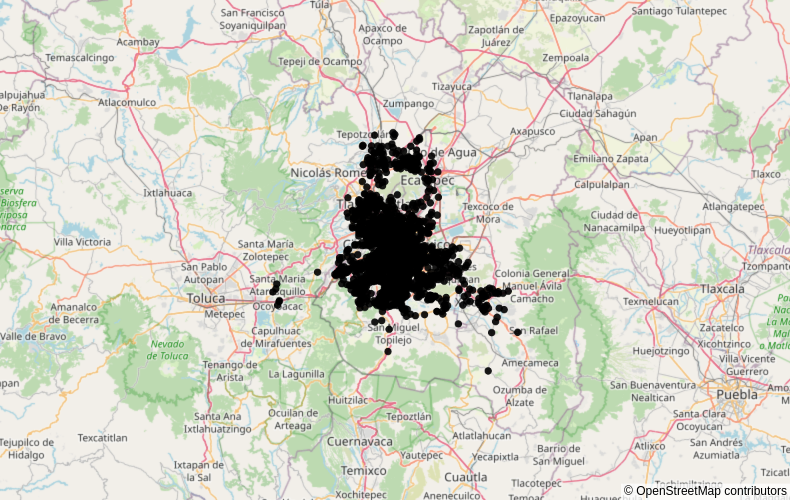

In [10]:
all_oxxo_fig = px.scatter_mapbox(oxxo_df, lat="latitude", lon="longitude",
                        hover_data=["Subregion","Region","name", "rating","comments"],
                        height=500)

all_oxxo_fig.update_layout(mapbox_style="open-street-map")
all_oxxo_fig.update_traces(marker=dict(size=8, color="black", opacity=0.9))
all_oxxo_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
all_oxxo_fig.show()

In [11]:
%%time
oxxo_coordinates = oxxo_df[["latitude","longitude"]].to_numpy()

geo_matrix_dist = GetGeoDistance(oxxo_coordinates)

# Inplace filling diagonal with np.inf
np.fill_diagonal(geo_matrix_dist, np.inf)
geo_matrix_dist[:5]

CPU times: user 4min 9s, sys: 486 ms, total: 4min 9s
Wall time: 4min 9s


array([[           inf,   759.99530021,   484.32355901, ...,
        13401.57374781, 11214.1571567 , 11417.28753781],
       [  759.99530021,            inf,   368.16118256, ...,
        12643.45181404, 10454.1848766 , 10657.80087926],
       [  484.32355901,   368.16118256,            inf, ...,
        12945.4451891 , 10769.22044266, 10967.07020488],
       [ 1924.73798105,  1986.90302844,  2114.9603104 , ...,
        13450.51684688, 11173.6170151 , 11427.21828729],
       [  934.66888573,  1396.26494821,  1032.48708633, ...,
        13698.33182311, 11568.7826305 , 11747.49970677]])

In [12]:
oxxo_closest_points = GetClosestPoint(oxxo_coordinates, geo_matrix_dist)
oxxo_closest_points.head()

point_a                    point_b  index_a  index_b  \
0  (19.3537529, -99.1899374)  (19.3519153, -99.1869152)        0      129   
1  (19.3483164, -99.1855199)  (19.3516214, -99.1859118)        1        2   
2  (19.3516214, -99.1859118)    (19.351655, -99.185903)        2      110   
3  (19.3416291, -99.2030682)  (19.3394322, -99.2038138)        3       17   
4  (19.3609272, -99.1852465)  (19.3599485, -99.1831651)        4       12   

     distance  
0  377.104110  
1  368.161183  
2    3.832597  
3  255.496556  
4  244.044214

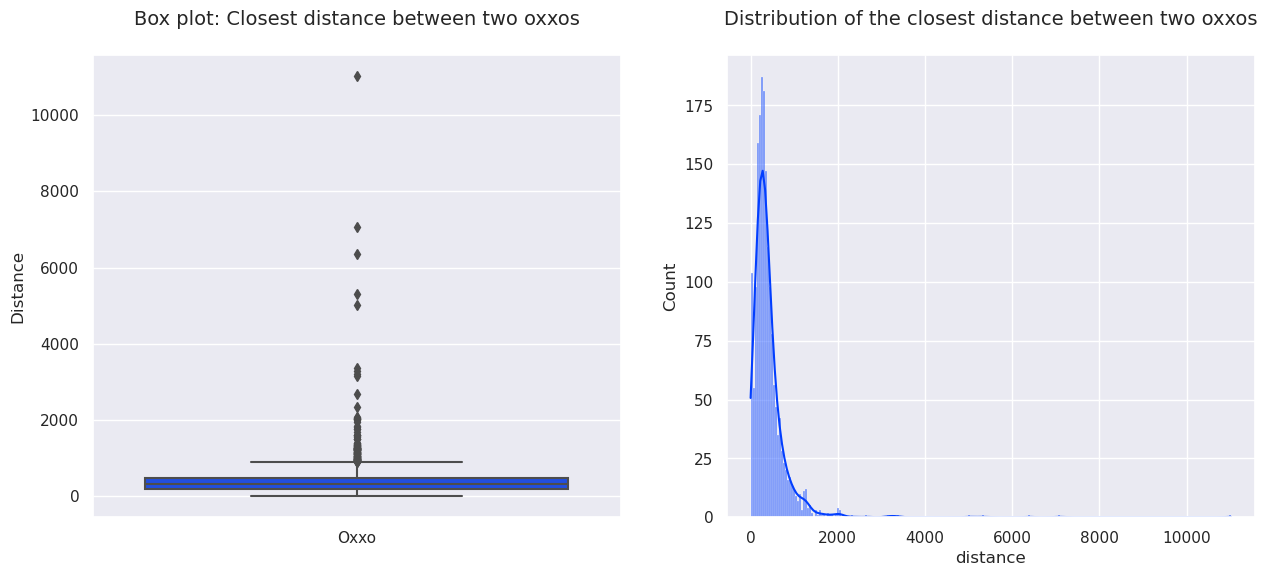

In [13]:
fig, axis = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(y=oxxo_closest_points["distance"], ax=axis[0])
axis[0].set_title("Box plot: Closest distance between two oxxos\n", size=14)
axis[0].set_ylabel("Distance")
axis[0].set_xticklabels(["Oxxo"])

sns.histplot(oxxo_closest_points["distance"], ax=axis[1], kde=True)
axis[1].set_title("Distribution of the closest distance between two oxxos\n", size=14)
plt.show()

In [14]:
# Outliers according to normal (right)
q3 = np.percentile(oxxo_closest_points.distance, 75)
q1 = np.percentile(oxxo_closest_points.distance, 25)
iqr = q3 - q1

outliers_right_by_iqr = oxxo_closest_points[oxxo_closest_points.distance >= (q3 + 1.5 * iqr)]

pcg_removed = outliers_right_by_iqr.shape[0] / oxxo_closest_points.shape[0] 
print(f"Number of outliers: {outliers_right_by_iqr.shape[0]}")
print(f"Percentage of rows removed: {pcg_removed * 100}%")

Number of outliers: 127
Percentage of rows removed: 7.063403781979978%


In [15]:
# Outliers according to distance >= 1125. 1km is about 10 or 15 minutes of walking
# So I choosed 1125 as threshold
outliers_right_by_dist = oxxo_closest_points[oxxo_closest_points.distance > 1125]
pcg_removed = outliers_right_by_dist.shape[0] / oxxo_closest_points.shape[0] 

print(f"Number of outliers: {outliers_right_by_dist.shape[0]}")
print(f"Percentage of rows removed: {pcg_removed * 100}%")

Number of outliers: 77
Percentage of rows removed: 4.282536151279199%


In [16]:
closest_no_outliers_right = oxxo_closest_points[oxxo_closest_points.distance < 1125]

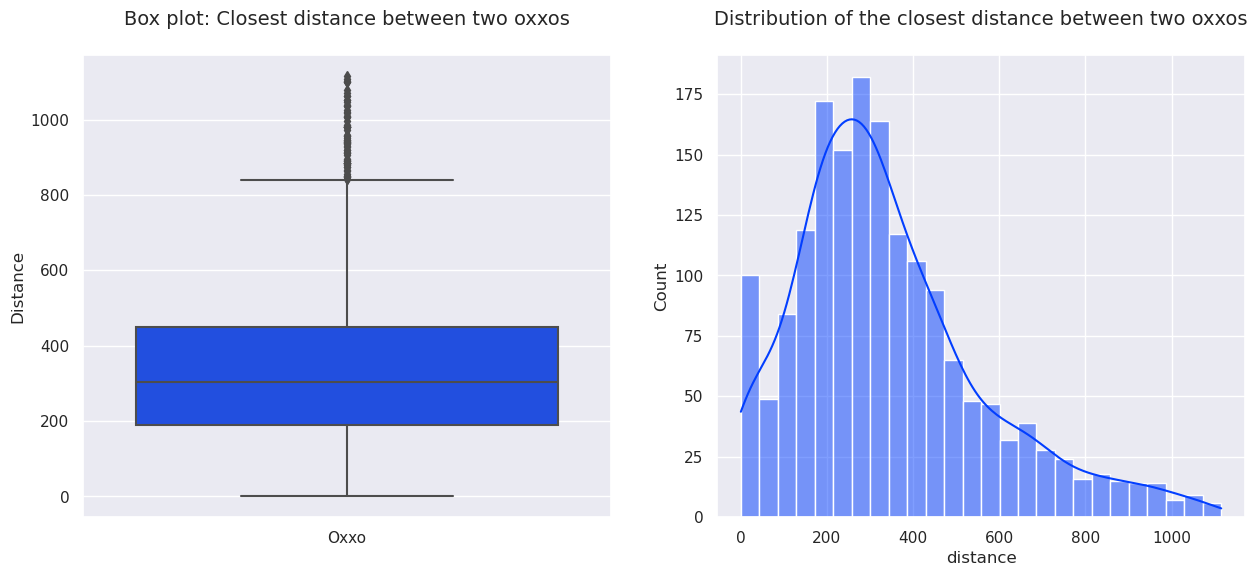

In [17]:
fig, axis = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(y=closest_no_outliers_right["distance"], ax=axis[0])
axis[0].set_title("Box plot: Closest distance between two oxxos\n", size=14)
axis[0].set_ylabel("Distance")
axis[0].set_xticklabels(["Oxxo"])

sns.histplot(closest_no_outliers_right["distance"], ax=axis[1], kde=True)
axis[1].set_title("Distribution of the closest distance between two oxxos\n", size=14)
plt.show()

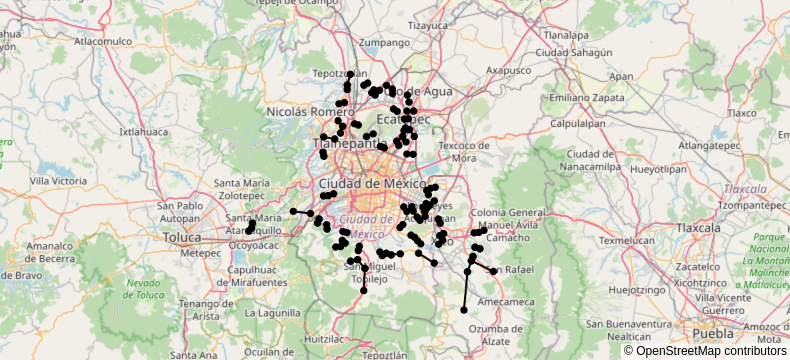

In [18]:
latitude, longitude, distance = ParserPointsPlotly(outliers_right_by_dist.point_a.values, 
                                                   outliers_right_by_dist.point_b.values,
                                                   outliers_right_by_dist.distance)

right_oxxo_outl = PlotPlottlyMapBox(longitude, latitude, distance)
right_oxxo_outl.show()

In [19]:
# Exploring False Positives. I choose a threshold of < 40 meters
# I've already explore those oxxo and oxxo closer than 40 meters seems to be false positives
# For now, here is the map of those < 40 meters

fp_left_by_dist = oxxo_closest_points[oxxo_closest_points.distance < 40]
pcg_removed = fp_left_by_dist.shape[0] / oxxo_closest_points.shape[0] 

print(f"Number of outliers: {fp_left_by_dist.shape[0]}")
print(f"Percentage of rows removed: {pcg_removed * 100}%")

Number of outliers: 98
Percentage of rows removed: 5.450500556173527%


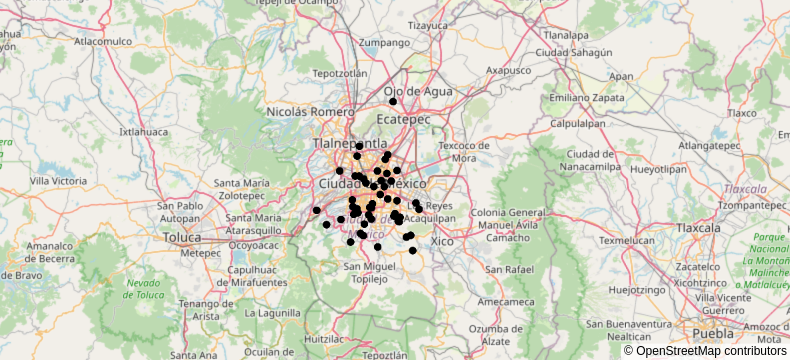

In [20]:
latitude, longitude, distance = ParserPointsPlotly(fp_left_by_dist.point_a.values,
                                                   fp_left_by_dist.point_b.values,
                                                   fp_left_by_dist.distance.values)

left_oxxo_outl = PlotPlottlyMapBox(longitude, latitude, distance)
left_oxxo_outl.show()

In [21]:
# Getting the points to delete
rmv_points = IdentifyFalsePoints(oxxo_coordinates,
                                 np.nan_to_num(oxxo_df.comments.values),
                                 40)

index_points_to_drop = rmv_points.fit_transform()

# Getting the full matrix distance
harv_matrix_distance = rmv_points.havernine(oxxo_coordinates)
np.fill_diagonal(harv_matrix_distance, np.inf)
harv_matrix_distance[:5]

array([[           inf,   762.57586285,   484.83568488, ...,
        13441.76392669, 11251.79123874, 11453.74211331],
       [  762.57586285,            inf,   370.20575982, ...,
        12681.06348862, 10489.23839888, 10691.67523789],
       [  484.83568488,   370.20575982,            inf, ...,
        12985.22086707, 10806.44933676, 11003.11672667],
       [ 1929.64870753,  1987.82845459,  2117.65703898, ...,
        13479.3215954 , 11199.66540346, 11452.19690228],
       [  938.37361098,  1404.11927666,  1038.26920578, ...,
        13744.68693552, 11612.60144999, 11790.13830579]])

In [22]:
geo_matrix_dist

array([[           inf,   759.99530021,   484.32355901, ...,
        13401.57374781, 11214.1571567 , 11417.28753781],
       [  759.99530021,            inf,   368.16118256, ...,
        12643.45181404, 10454.1848766 , 10657.80087926],
       [  484.32355901,   368.16118256,            inf, ...,
        12945.4451891 , 10769.22044266, 10967.07020488],
       ...,
       [13401.57374781, 12643.45181404, 12945.4451891 , ...,
                   inf,  2310.46554444,  2025.48519825],
       [11214.1571567 , 10454.1848766 , 10769.22044266, ...,
         2310.46554444,            inf,   374.77127555],
       [11417.28753781, 10657.80087926, 10967.07020488, ...,
         2025.48519825,   374.77127555,            inf]])

In [23]:
# Both matrices seems similar, I'll use the geodesic distance as a reference
# and I'll delete "the same" oxxos and those outliers (distance > 1125)

# Removing same oxxo

oxxo_clear_df = oxxo_df.drop(index_points_to_drop, axis=0).reset_index(drop=True)
print(f"Shape new frame: {oxxo_clear_df.shape}")

oxxo_coordinates_clear = oxxo_clear_df[["latitude","longitude"]].to_numpy()
print(f"Shape coordinate points: {oxxo_coordinates_clear.shape}")

# Recalculating distances 
geo_matrix_dist_clear = GetGeoDistance(oxxo_coordinates_clear)
np.fill_diagonal(geo_matrix_dist_clear, np.inf)

oxxo_closest_points_clear = GetClosestPoint(oxxo_coordinates_clear, geo_matrix_dist_clear)
print(f"Shape closest point df: {oxxo_closest_points_clear.shape}")

Shape new frame: (1748, 15)
Shape coordinate points: (1748, 2)
Shape closest point df: (1748, 5)


In [24]:
# Removing outliers by distance

keep_index = oxxo_closest_points_clear[oxxo_closest_points_clear.distance < 1125]
keep_index = keep_index[["index_a", "index_b"]].to_numpy().reshape(-1,)
keep_index = np.unique(keep_index)
print(f"Shape of rows to keep: {keep_index.shape}")

oxxo_clear_df = oxxo_clear_df.iloc[keep_index]
print(f"Shape new frame: {oxxo_clear_df.shape}")
      
pcg_removed = (oxxo_df.shape[0] - oxxo_clear_df.shape[0]) / oxxo_df.shape[0]
print(f"Percentage of total rows removed: {pcg_removed * 100}%")

oxxo_coordinates_clear = oxxo_clear_df[["latitude","longitude"]].to_numpy()
print(f"Shape coordinate point: {oxxo_coordinates_clear.shape}")

# Recalculating distances 
geo_matrix_dist_clear = GetGeoDistance(oxxo_coordinates_clear)
np.fill_diagonal(geo_matrix_dist_clear, np.inf)

oxxo_closest_points_clear = GetClosestPoint(oxxo_coordinates_clear, geo_matrix_dist_clear)
print(f"Shape closest point df: {oxxo_closest_points_clear.shape}")

Shape of rows to keep: (1670,)
Shape new frame: (1670, 15)
Percentage of total rows removed: 7.119021134593993%
Shape coordinate point: (1670, 2)
Shape closest point df: (1670, 5)


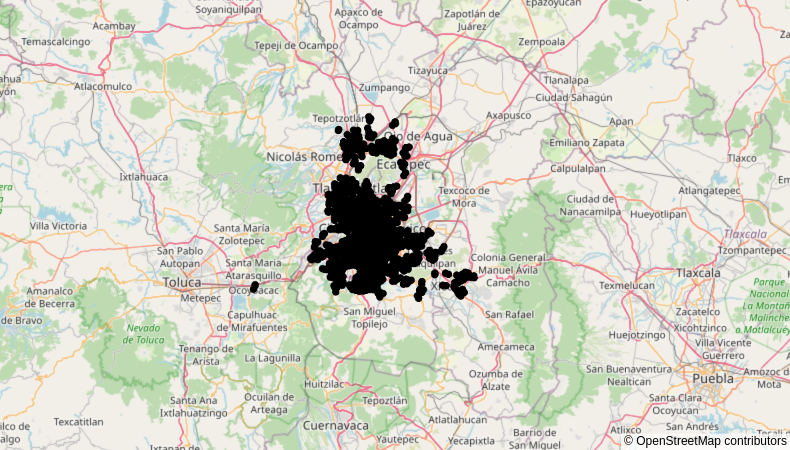

In [25]:
latitude, longitude, distance = ParserPointsPlotly(oxxo_closest_points_clear.point_a.values,
                                                   oxxo_closest_points_clear.point_b.values,
                                                   oxxo_closest_points_clear.distance.values)

oxxo_shortest = PlotPlottlyMapBox(longitude, latitude, distance)
oxxo_shortest.show()

<AxesSubplot: xlabel='distance', ylabel='Count'>

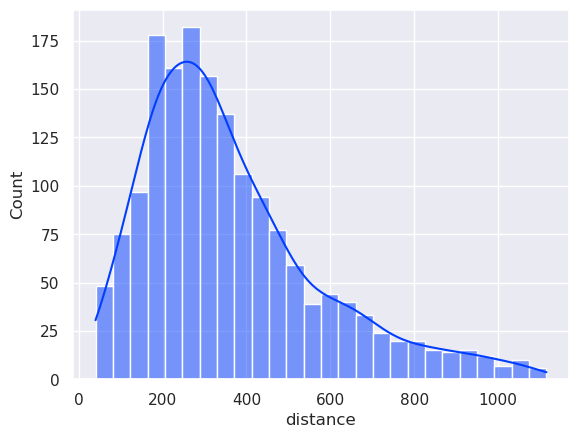

In [26]:
sns.histplot(oxxo_closest_points_clear.distance, kde=True)

In [27]:
oxxo_clear_df.to_csv("../data/oxxo/oxxo_clean_data.csv", index=False)

In [28]:
oxxo_closest_points_clear

point_a                    point_b  index_a  index_b  \
0     (19.3537529, -99.1899374)  (19.3519153, -99.1869152)        0      126   
1     (19.3483164, -99.1855199)    (19.351655, -99.185903)        1      107   
2     (19.3416291, -99.2030682)  (19.3394322, -99.2038138)        2       16   
3     (19.3609272, -99.1852465)  (19.3599485, -99.1831651)        3       11   
4     (19.3580665, -99.1844114)  (19.3599485, -99.1831651)        4       11   
...                         ...                        ...      ...      ...   
1665   (19.4093558, -99.120045)  (19.4078033, -99.1214175)     1665      932   
1666  (19.4151761, -99.1042633)  (19.4172241, -99.1026671)     1666     1388   
1667  (19.2631302, -99.1053816)  (19.2604749, -99.1111195)     1667     1114   
1668  (19.2739901, -99.1241512)  (19.2743458, -99.1206057)     1668     1669   
1669  (19.2743458, -99.1206057)  (19.2772486, -99.1220439)     1669     1072   

        distance  
0     377.104110  
1     371.756224  
2     255.496556  
3     244.044214  
4     246.063624  
...          ...  
1665  224.312447  
1666  281.959476  
1667  671.006107  
1668  374.771276  
1669  355.114174  

[1670 rows x 5 columns]